Here, we aim to integrate differential analysis results (treated vs. non-treated) toward making a final list of genes which are significantly methylated, expressed and stabilized.

=> table of these genes with all logFCs, pvalues and screening scores.

<!-- # Select target genes

## Rho_down & Exp_down & Hyper_m6A

'SQLE', 'INTS5'
#### SQLE 
> Value of SQLE Expression in Prognostic Evaluation of Patients with Acute Myeloid Leukemia - https://pubmed.ncbi.nlm.nih.gov/33554790/


#### INTS5
> Coordinated Alterations in RNA Splicing and Epigenetic Regulation Drive Leukemogenesis - https://www.nature.com/articles/s41586-019-1618-0
>> Transcriptional pausing was also evident at INTS5 and INTS14 in SRSF2 mutant cells (Extended Data Fig. 7r, ​,s),s), which, in combination with aberrant splicing of several Integrator subunits (Supplementary Table 24), suggested impaired function of the entire Integrator complex in SRSF2 mutant cells -->

In [1]:
import sys 
import pandas as pd 
import numpy as np
from matplotlib.pyplot import subplots
from itertools import chain, product
from matplotlib_venn import venn3,venn3_circles, venn3_unweighted
from venn import venn 

import upsetplot as us
from matplotlib.backends.backend_pdf import PdfPages

sys.path.append('../scripts')

from util import *

In [27]:
from matplotlib import font_manager as fm
from matplotlib import rcParams, rc_context

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in fm.fontManager.ttflist}

rcParams['font.family'] = ['Arial']
# rcParams['font.family'] = ["Times New Roman"]

In [28]:
# wd = '/rumi/shams/abe/Projects/Decitabine-treatment/'
wd = '/data_gilbert/home/aarab/AML/Decitabine-treatment/DAC'

# Intersectional genes
> start with rho/expression/stability/methylation - no TE. Then, relax q-values for the individual lists so that you start with a good number of genes. So that we can get a good number of overlaps. Separate TE and stability - don’t care about both at the same time. Initially just remove stability and TE

## Load data
Comparing treated with Decitabine vs. non-treated:
- **$\Delta$RNA methylation**  (hl60 cell line)
- **$\Delta$Translational efficiency** (hl60 cell line)
- **$\Delta$RNA expression** (For all 6 AML cell lines)
- **$\Delta$RNA stability** (For all 6 AML cell lines)
- **$\Delta$Phenotype, CRISPRi-screen $\rho$(rho) score** (hl60 and molm13 cell lines) 

In [29]:
comps = load_data(comparisons=True,wd=wd)

In [30]:
scrns = load_data(screens=True,wd=wd)

In [31]:
# comps['delta_te'].iloc[:,2].hist()
# plt.title('ΔTE - FDR Distribution')
# plt.show()

Find top genes across all cell lines and high throughput experiments:


In [32]:
_,_ = find_top(
    scrns["hl60_exp1_gamma"].astype(float),
    "gamma score", 0.1,
    "Mann-Whitney p-value", 0.05
)

up:  27
down: 1147


In [33]:
Top = {}

In [34]:
set_Top_Rho

<function util.set_Top_Rho(sc_thr, pv_thr, cells='hl60', exps='exp1', data=None)>

In [35]:
Top['Mtyl'] = set_Top_Mtyl(1,0.05,data=comps)
print('_'*30)
Top['Rho'] = set_Top_Rho(0.1,0.05,data=scrns)
print('_'*30)
Top['TE']   = set_Top_TE  (0.1,0.20,data=comps)
print('_'*30)
Top['Exp']  = set_Top_Exp (0.1,0.05,data=comps,comp='hl60_72h')
# Top['Exp'] = set_Top_Exp (0.1,0.05,data=comps,comp='hl60_72h_only')
# print('_'*30)
Top['Stbl'] = set_Top_Stbl(0.1,0.05,comps)

Subset Top Mtyl data frame:
up:  1704
down: 1210
(fc_thr=1, pv_thr=0.05)
______________________________
Subset Top Rho data frame:
(hl60 / exp1)
(sc_thr=0.1, pv_thr=0.05)
up:  592
down: 701
______________________________
Subset Top TE data frame:
up:  157
down: 41
(te_thr=0.1, fdr_thr=0.2)
______________________________
Subset Top Exp data frame:
up:  3512
down: 2732
(hl60_72h)
(fc_thr=0.1, pv_thr=0.05
Subset Top Stbl data frame:
up:  542
down: 422
(hl60_72h)
(fc_thr=0.1, pv_thr=0.05


In [36]:
Top['Rho']["up"].shape[0] + Top['Rho']["down"].shape[0]

1293

#### Add `hl60_72h_only` result to `Top_Exp`

In [37]:
# u,d,_ = set_Top_Exp (0.1,0.05,data=comps,comp='hl60_72h_only').items()

### Intersection of all genes across different datasets
Select top gene names 

In [38]:
Exp_up = set(Top['Exp']['up'].gene_name.to_list())# + u[1].gene_name.tolist())
Rho_up = set(Top['Rho']['up'].index.tolist())
Stbl_up = set(Top['Stbl']['up'].gene_name.tolist())
TE_up = set(Top['TE']['up'].gene_name.tolist())
Hyper_m6A = set(Top['Mtyl']['up'].gene_name.tolist())

Exp_down = set(Top['Exp']['down'].gene_name.tolist())# + d[1].gene_name.tolist())
Stbl_down = set(Top['Stbl']['down'].gene_name.tolist())
Rho_down = set(Top['Rho']['down'].index.tolist())
TE_down = set(Top['TE']['down'].gene_name.tolist())
Hypo_m6A = set(Top['Mtyl']['down'].gene_name.tolist())

In [39]:
'MYBBP1A' in Rho_down 

True

In [40]:
'INTS5' in Exp_down

True

## Plots

### UpSet plots 

In [41]:
upset_data = {
    'Hyper_m6A':Hyper_m6A,
    # 'Hypo_m6A':Hypo_m6A,

    'Exp_up':Exp_up,
    'Rho_up':Rho_up,
    # 'Stbl_up':Stbl_up,
    'TE_up':TE_up,

    'Exp_down':Exp_down,
    # 'Stbl_down':Stbl_down,
    'Rho_down':Rho_down,
    'TE_down':TE_down
}

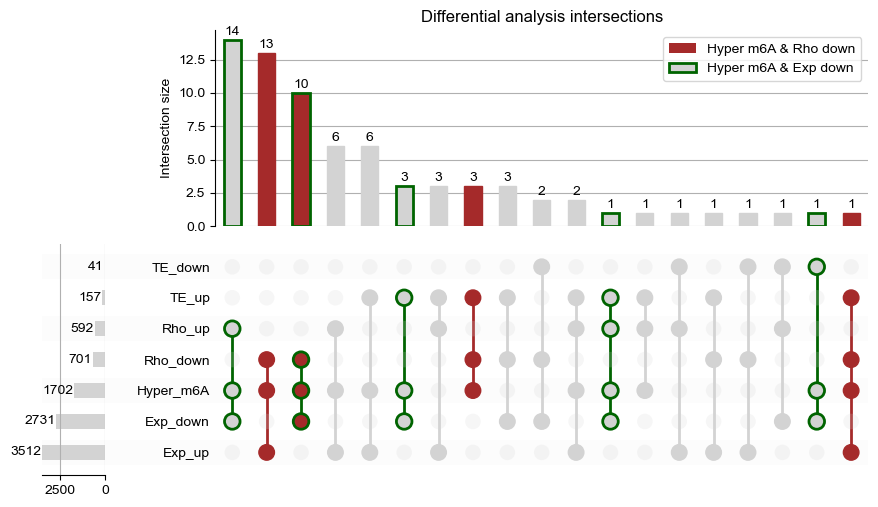

In [42]:
with PdfPages('intersectional-genes/comparisons_upset_plot.pdf') as pdf:
    # Hyper_m6A_upset_data
    fig1 = plt.figure()
    upset1 = us.UpSet(
        us.from_contents(upset_data),
        min_degree=3,
        sort_by='cardinality',
        # orientation='vertical',
        show_counts=True,
        # totals_plot_elements=
        other_dots_color=0.2,
        facecolor='lightgrey'
    )
    upset1.style_subsets(
        present=["Rho_down","Hyper_m6A"], 
        # absent='Hypo_m6A',
        label="Hyper m6A & Rho down", 
        facecolor='brown'
        #, edgecolor='dimgrey',linewidth=0.5,linestyle='--'
    )
    
    upset1.style_subsets(
        present=["Exp_down","Hyper_m6A"], 
        # absent='Hypo_m6A',
        label="Hyper m6A & Exp down", 
        # facecolor='brown', 
        edgecolor='darkgreen',linewidth=2#,linestyle='--'
    )

    upset1.plot(fig=fig1)
    plt.title('Differential analysis intersections',fontsize=12)
    pdf.savefig(bbox_inches='tight')

### Venn diagrams
- https://pypi.org/project/venn/


In [43]:
def iter_by_two(input1,input2,input3):
    # inputs are variable names 
    # it will give 8 combinations 
    out = []
    for comb in list(product(input1,input2,input3)):
        a,b,c = comb
        out.append([a,b,c])
    return out 


def prep_studeis(first,second,extra=None):
    studies = iter_by_two([f'{first}_up', f'{first}_down'],[f'{second}_up', f'{second}_down'],['Hyper_m6A', 'Hypo_m6A'])
    if extra: studies = [[s[0].replace(first,extra),s[0],s[1],s[2]] for s in studies]
    return studies

def plot_combinations(studies):
    _, top_axs = subplots(ncols=4, nrows=1, figsize=(18, 8),dpi=500)
    _, bot_axs = subplots(ncols=4, nrows=1, figsize=(18, 8),dpi=500)
    # cmaps = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
    # letters = iter(ascii_uppercase)

    for std,ax in zip(studies,chain(top_axs, bot_axs)):
        data = {}
        data = dict([[a,set(eval(a))] for a in std])
        venn(data,fontsize=10,legend_loc="upper left", ax=ax)

#### Expression, Stability and _rho_

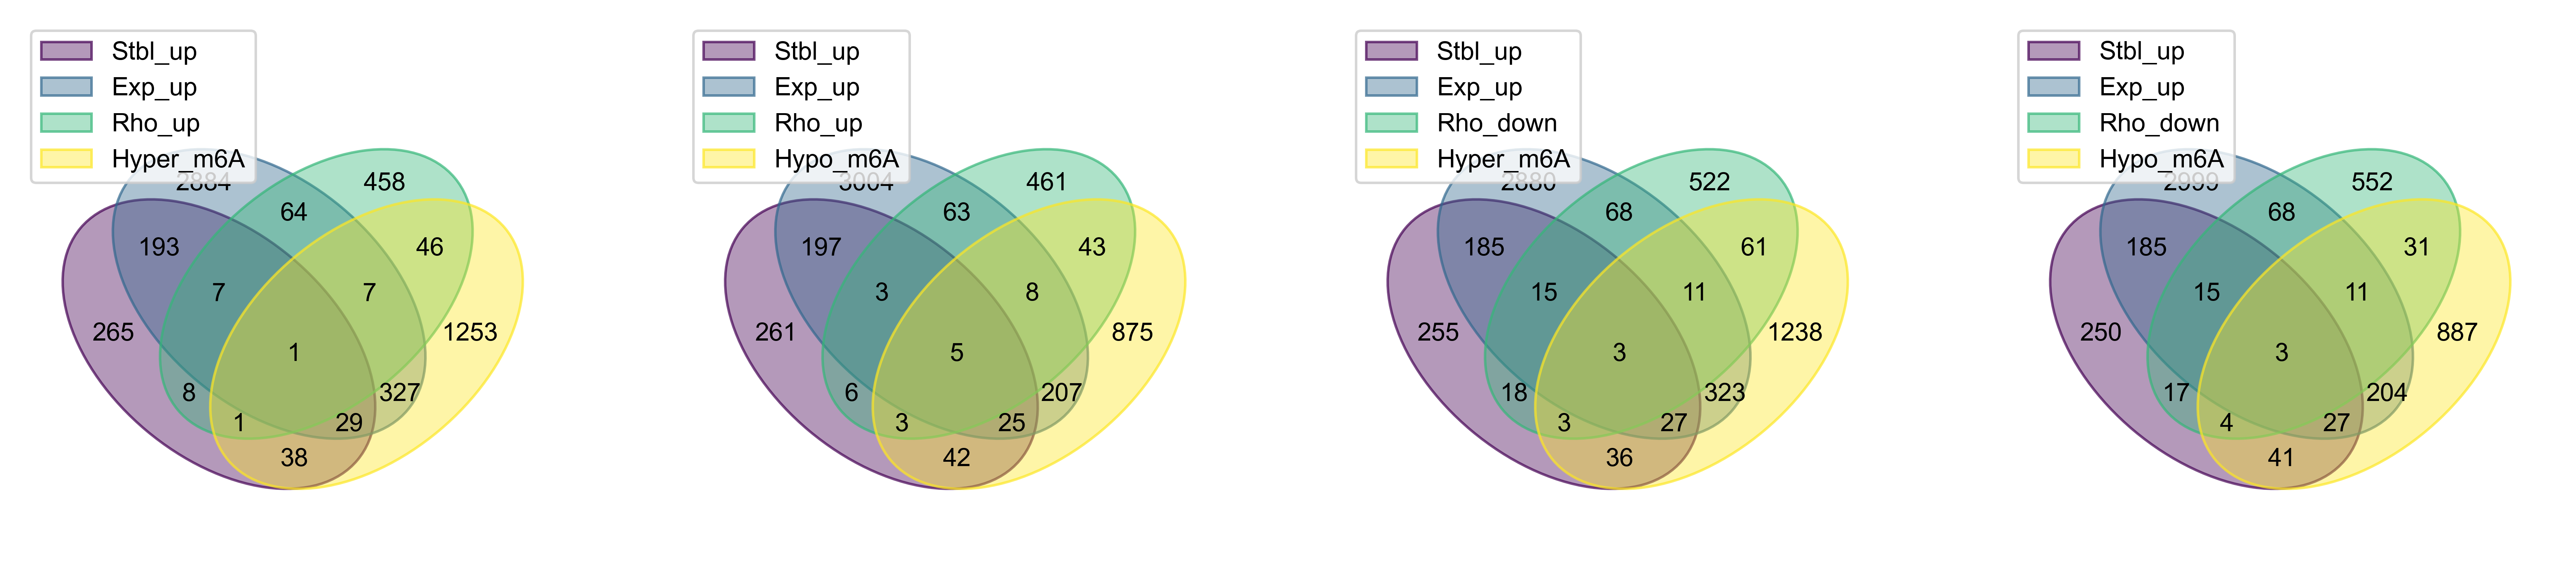

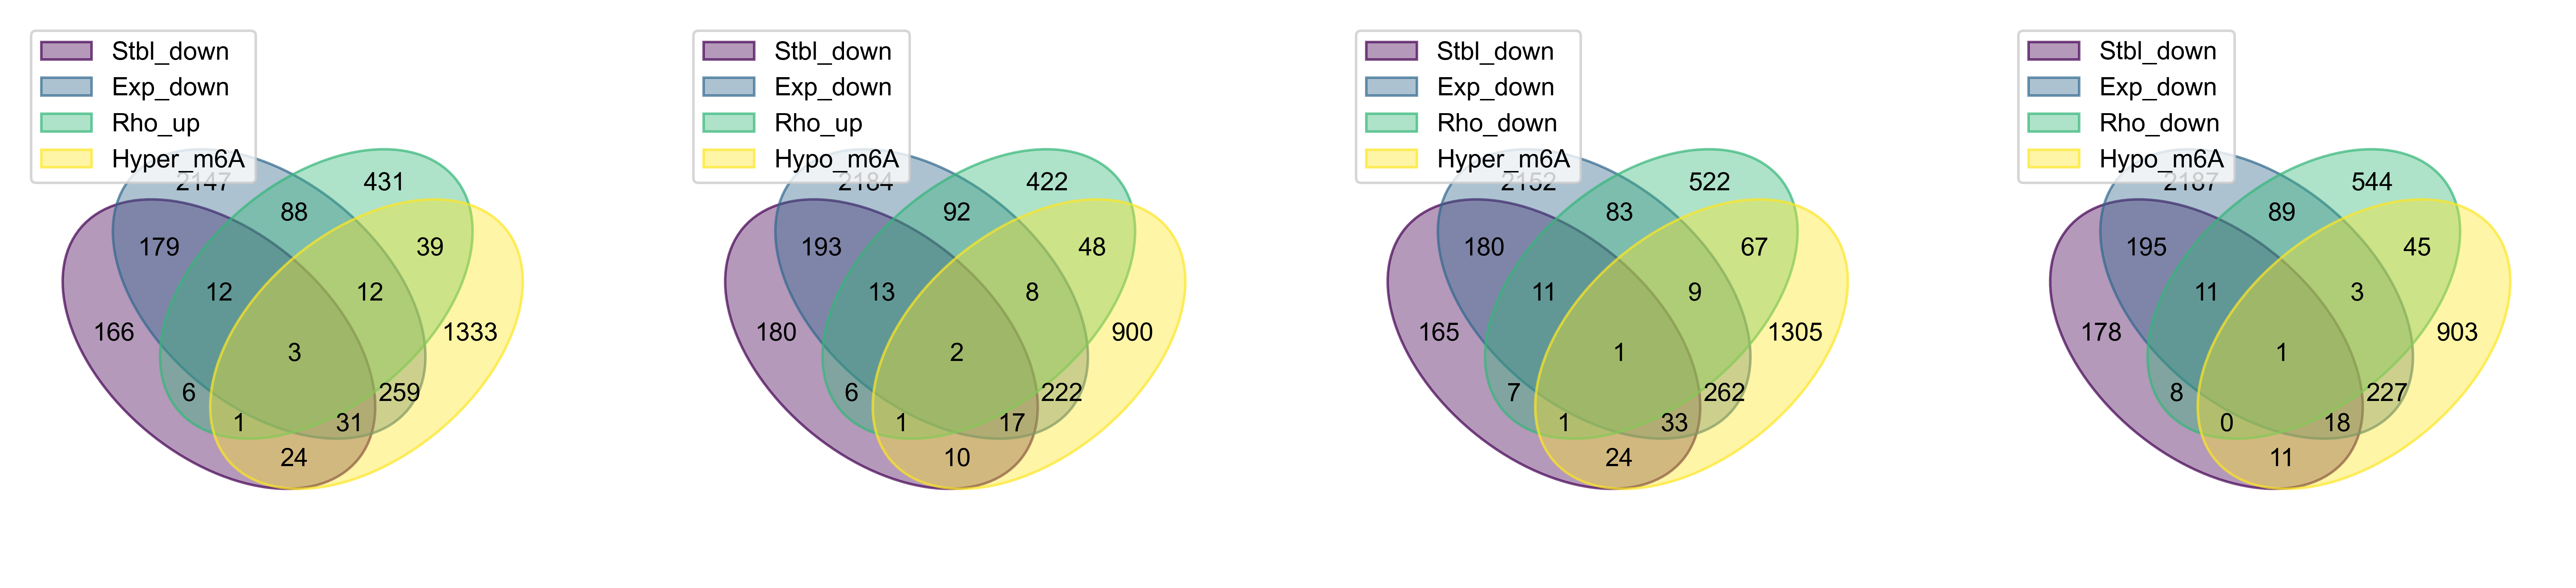

In [44]:
first = 'Exp'
second= 'Rho'
extra = 'Stbl'

plot_combinations(
    prep_studeis(first,second,extra)
)

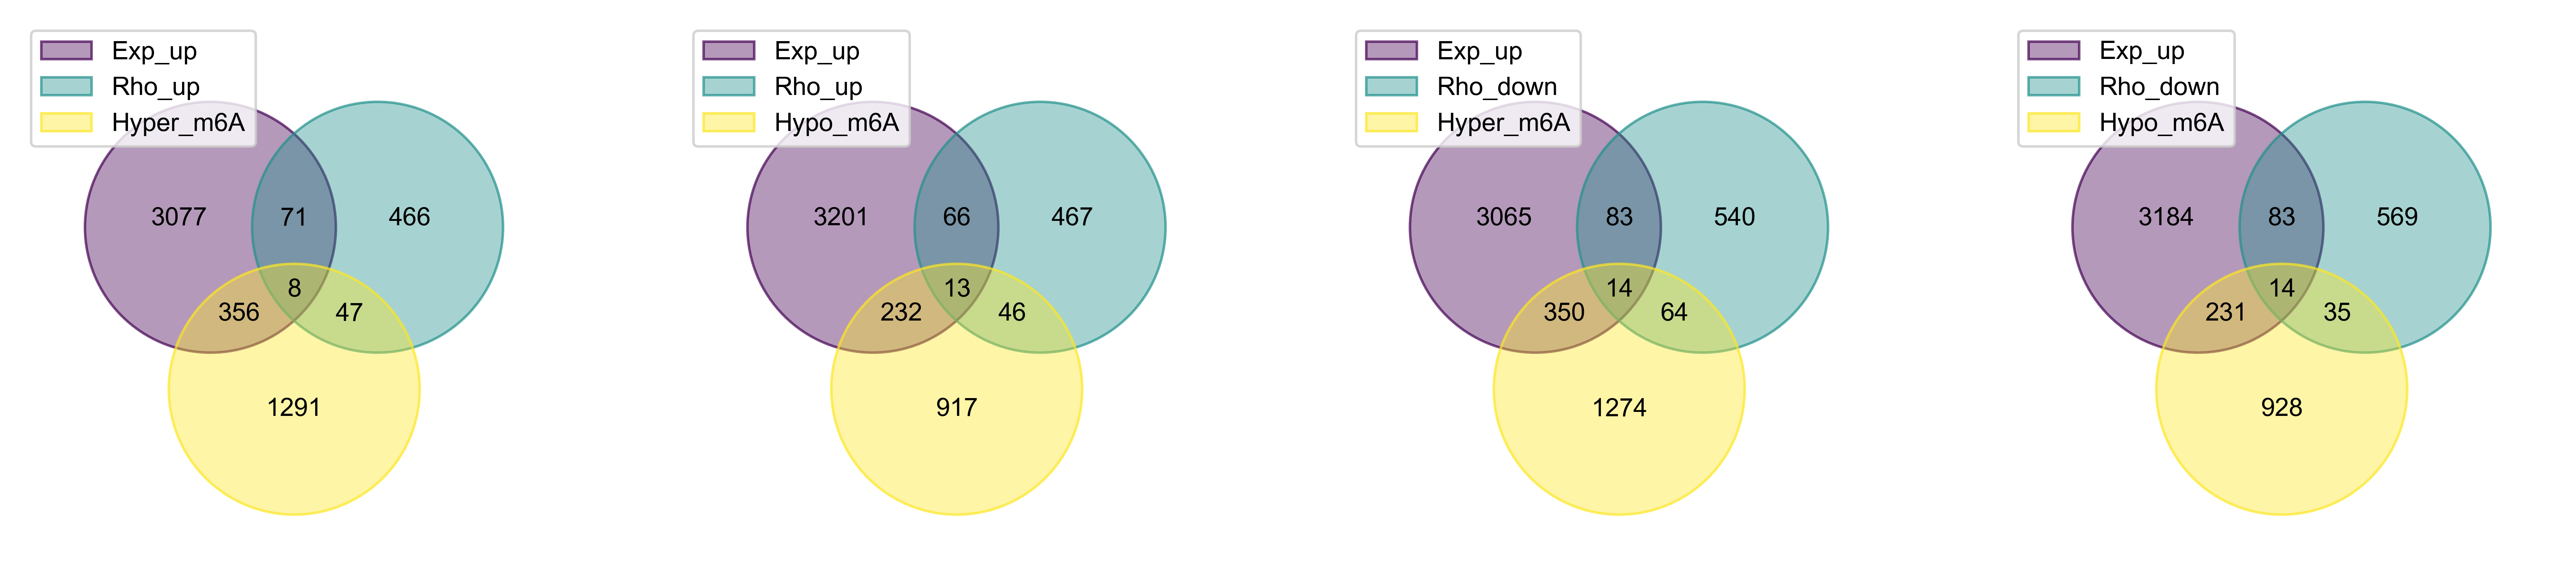

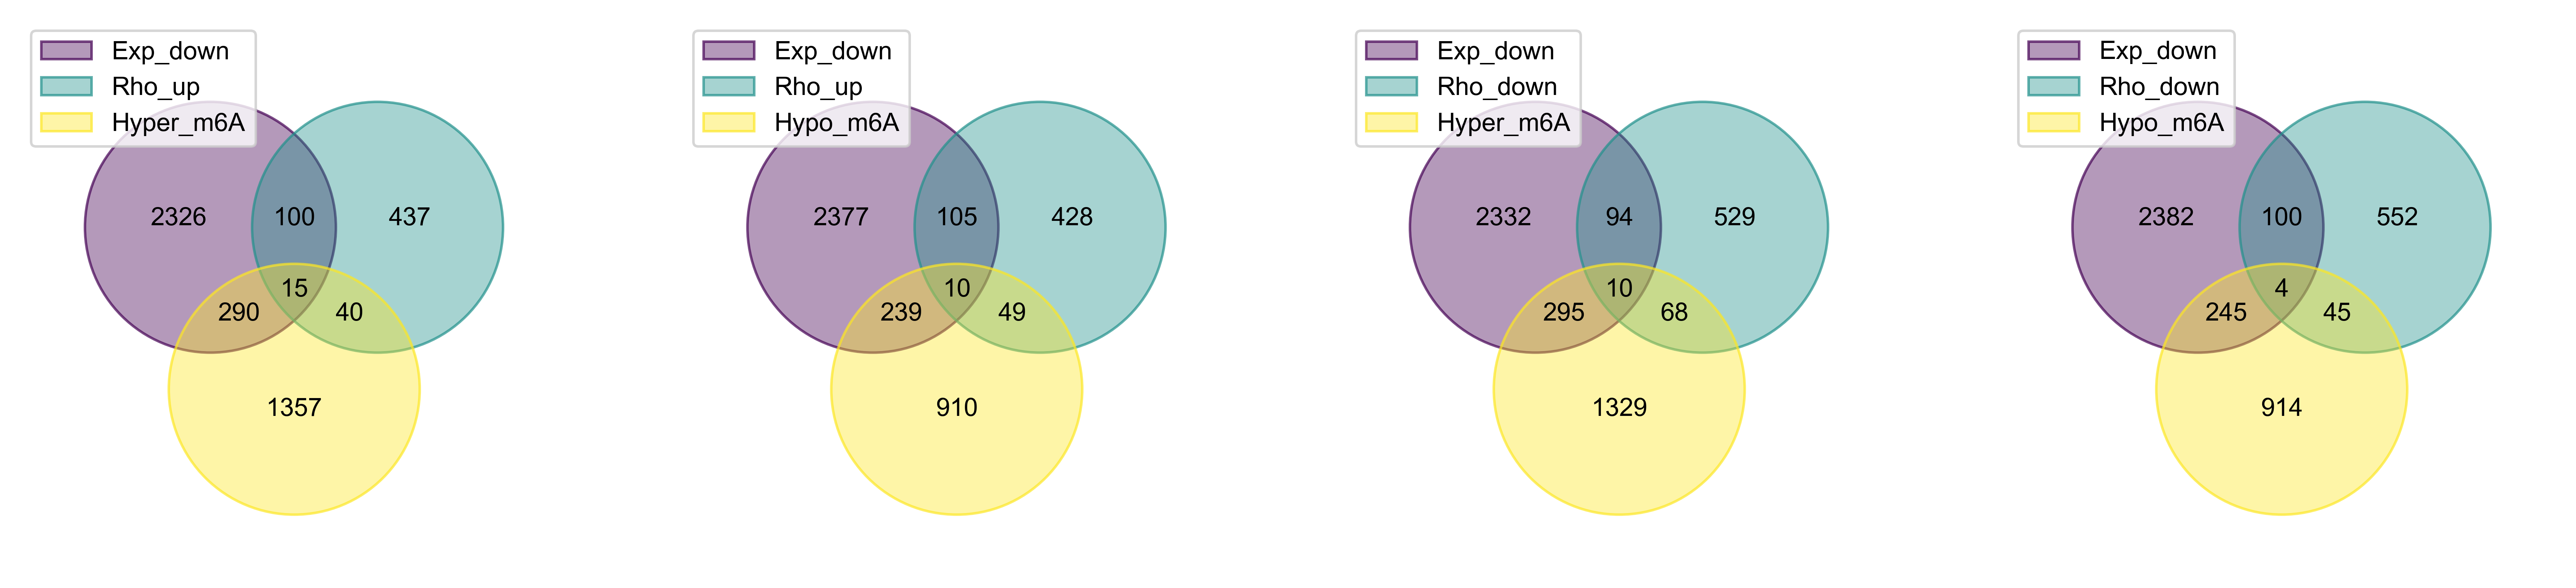

In [45]:
first = 'Exp'
second= 'Rho'

plot_combinations(
    prep_studeis(first,second)
)

#### TE combinations

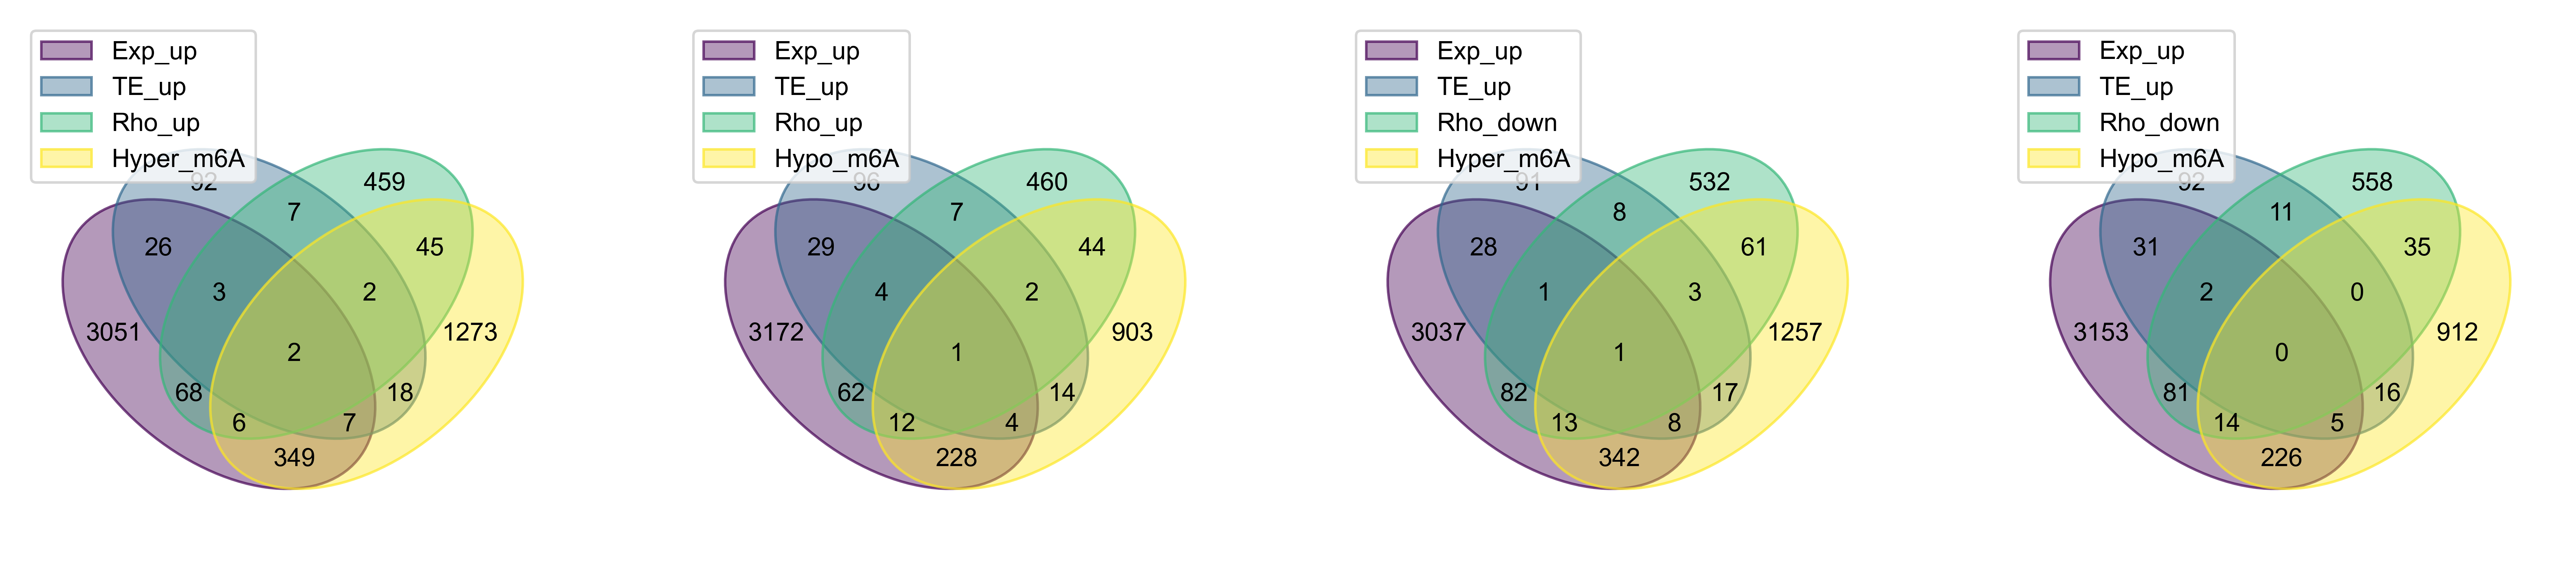

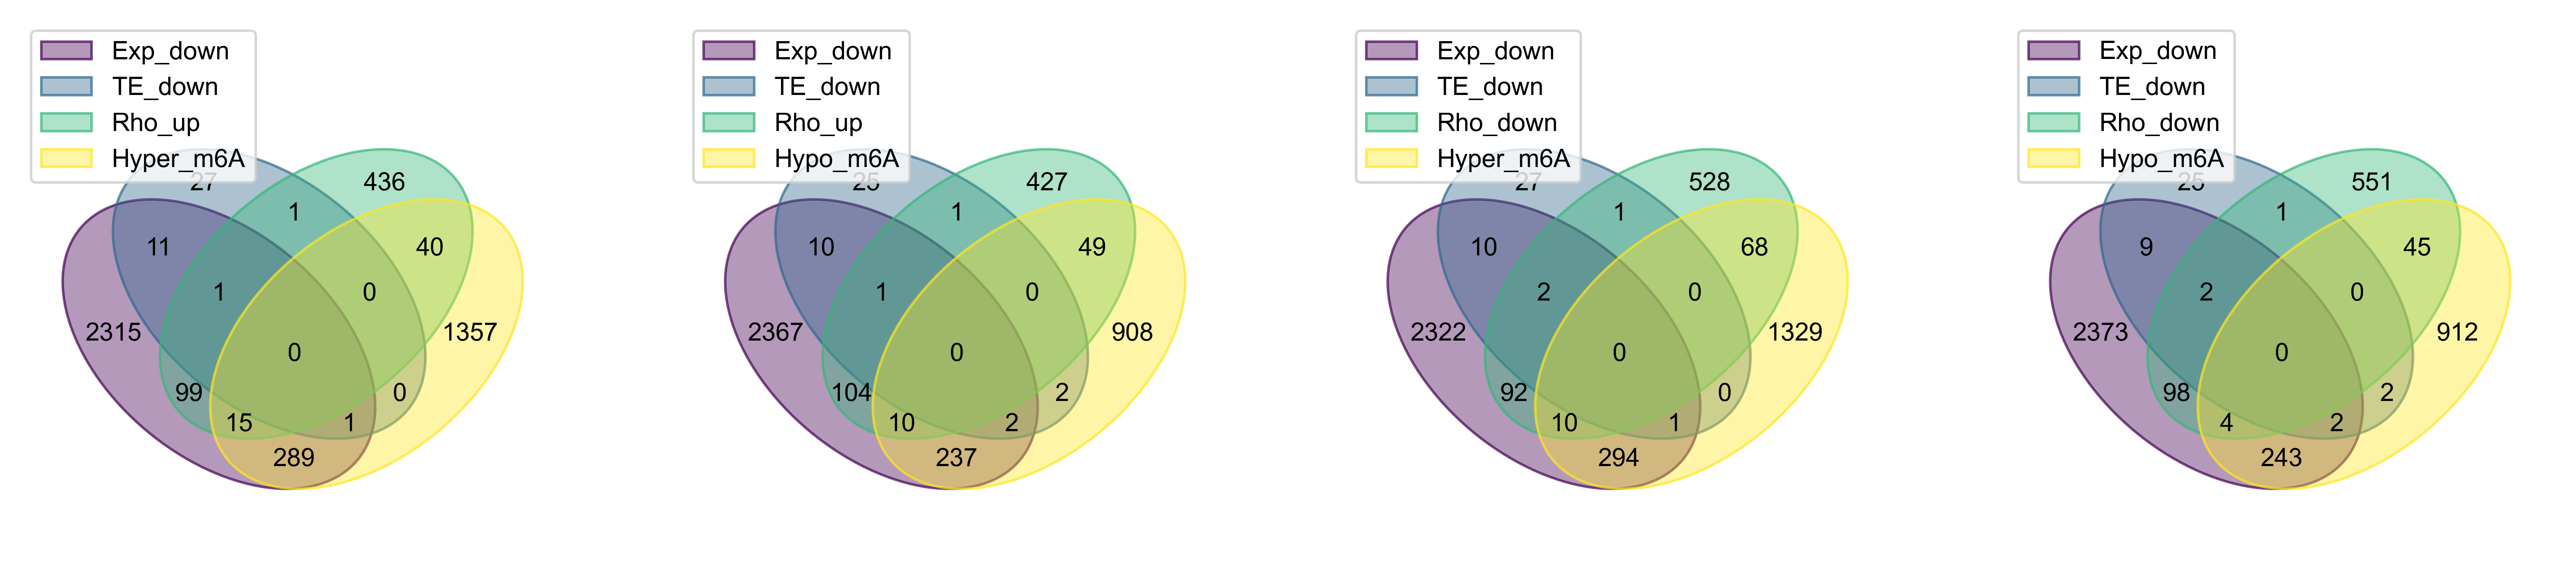

In [46]:
first = 'TE'
second= 'Rho'
extra = 'Exp'
plot_combinations(
    prep_studeis(first,second,extra)
)

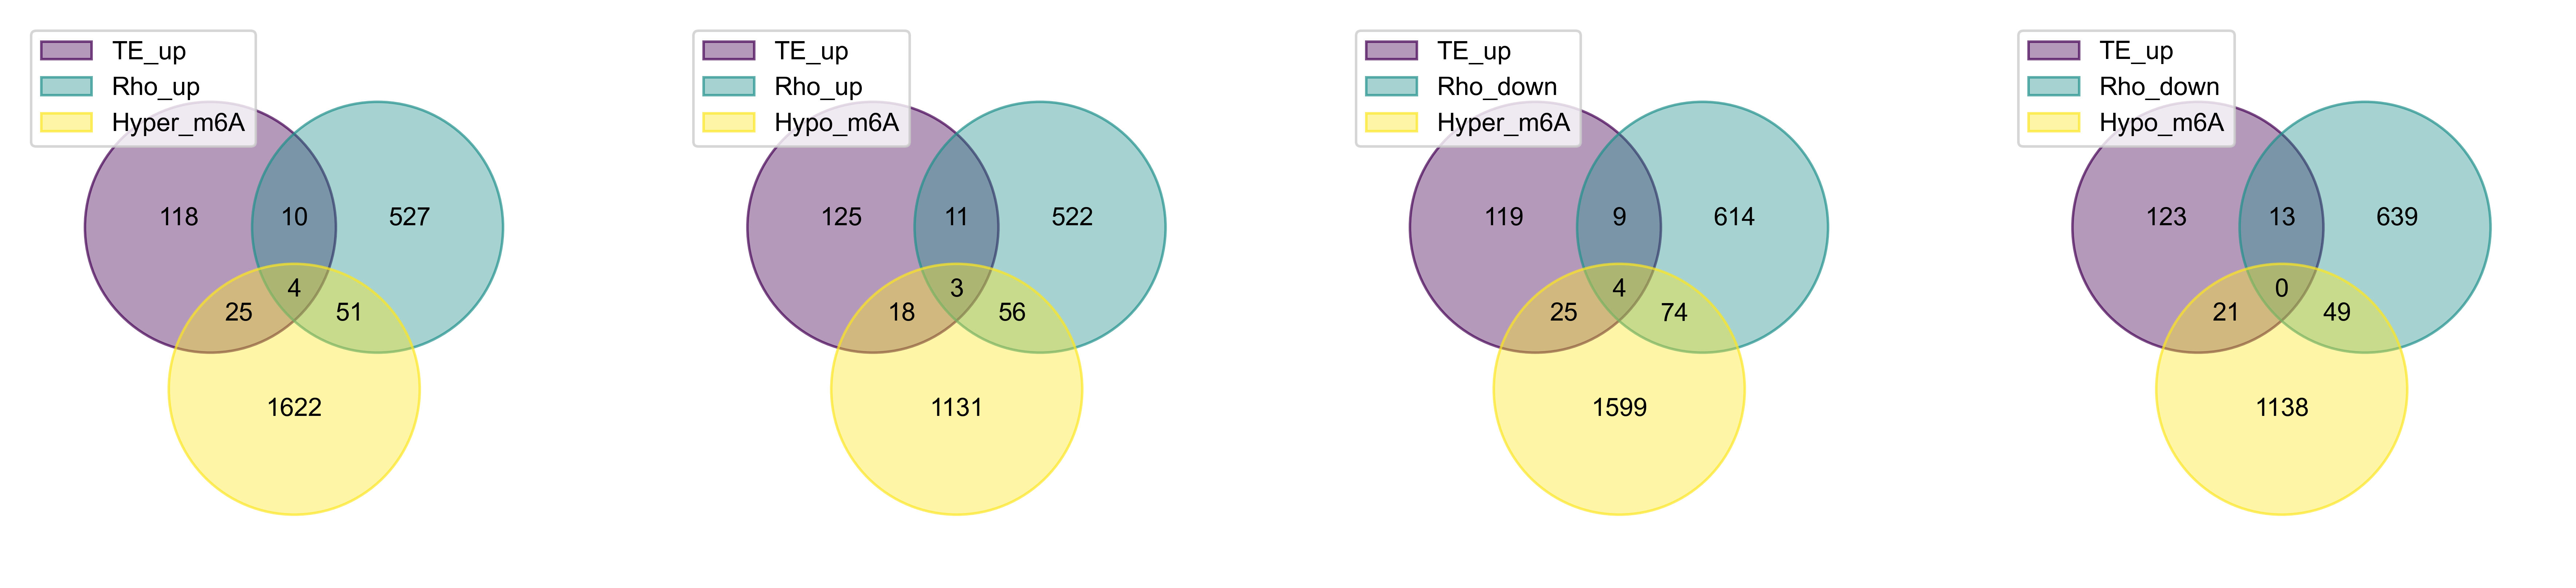

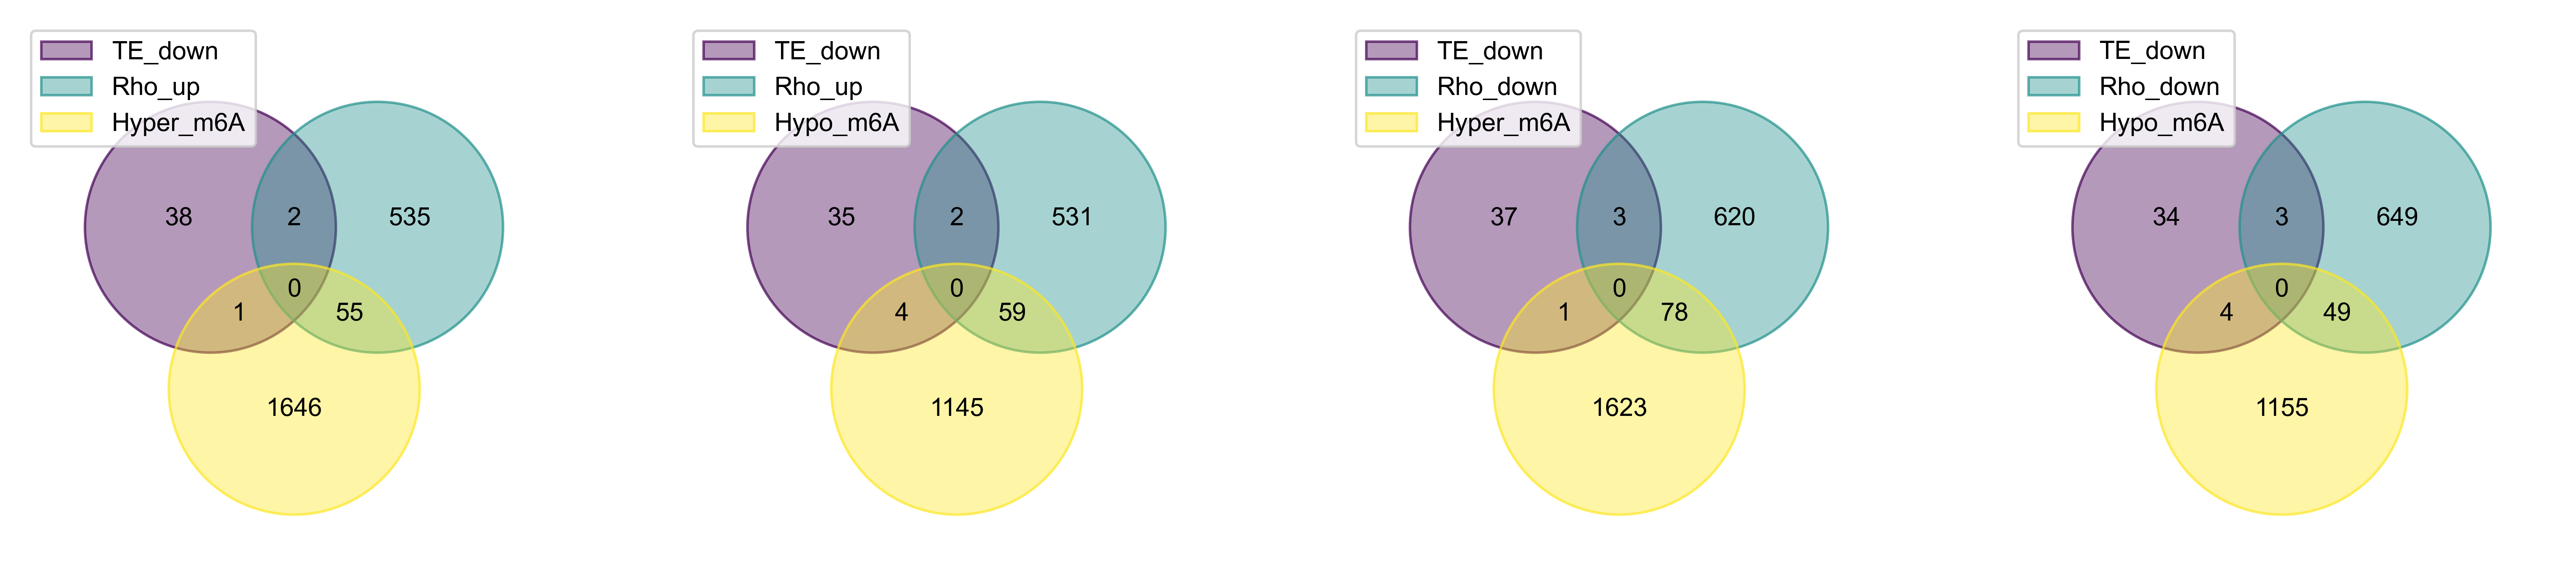

In [47]:
first = 'TE'
second= 'Rho'

plot_combinations(
    prep_studeis(first,second)
)

### Venn diagram of the intersection used for downstream experiments

In [48]:
venn_genes_label = ''
for gene in Exp_down.intersection(Rho_down).intersection(Hyper_m6A):  
    if gene == 'SQLE' or gene == 'INTS5':
        # g = "\033[1m" + gene + "\033[0m "
        g = gene + "*"
        
    else: 
        g = gene
    
    venn_genes_label = venn_genes_label + g + '\n'

venn_genes_label = venn_genes_label[:-1]

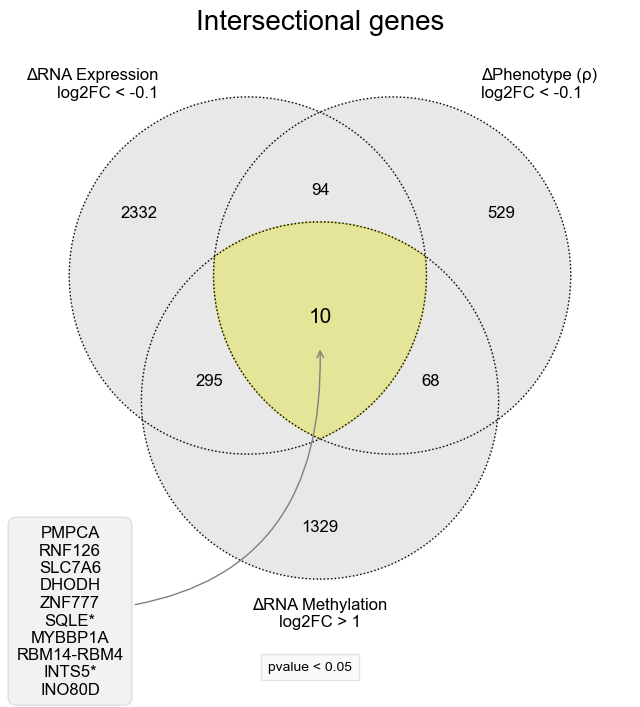

In [49]:
plt.figure(figsize=(8,8))

# Make venn diagram                                                                                                                                                             
v = venn3_unweighted(
    [Exp_down,Rho_down,Hyper_m6A],('ΔRNA Expression\nlog2FC < -0.1','ΔPhenotype (ρ)\nlog2FC < -0.1','ΔRNA Methylation\nlog2FC > 1')
    ,normalize_to=0.5
)

for x in ['100','010','001','110','101','011']:
    v.get_patch_by_id(x).set_alpha(0.5)
    v.get_patch_by_id(x).set_color('lightgrey')
    v.get_label_by_id(x).set_fontsize(12)

v.get_patch_by_id('111').set_color('y')
v.get_label_by_id('111').set_fontsize(15)


c = venn3_circles(
    (1,1,1,1,1,1,1), linestyle='dashed'
    ,normalize_to=0.5
)
for i,_ in enumerate(c):
    c[i].set_lw(1.0)
    c[i].set_ls('dotted')

plt.title("Intersectional genes", fontsize=20)
plt.annotate(
    venn_genes_label, xy=v.get_label_by_id('111').get_position() - np.array([0, 0.05]), 
    xytext=(-180,-250),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    fontsize=12, 
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray')
)

plt.figtext(
    0.5, 0.08, "pvalue < 0.05", ha="center", fontsize=10, 
    bbox={"facecolor":"lightgray", "alpha":0.1, "pad":5}
)

plt.savefig('intersectional-genes/venn_plot_Exp_down_Rho_down_Hyper_m6A.pdf')
plt.show()

## Generate final merged table

In [50]:
all_genes = {}
all_genes_list = []

for i,j,k in iter_by_two(['up', 'down'],['up', 'down'],['Hyper', 'Hypo']):
    
    for third in ['Exp','TE','Stbl']:
        name = f'Rho_{i} & {k}_m6A & {third}_{j}'
        genes = list(set(eval(f'Rho_{i}')).intersection(eval(f'{k}_m6A'),eval(f'{third}_{j}')))
        all_genes[name] = genes
        all_genes_list = all_genes_list + genes
        
all_genes_list = set(all_genes_list)

In [51]:
def get_intersect_df(genes, data, key=None):
    # get intersects 
    if key is not None: 
        df = data[key]
    else: 
        df = data

    out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(genes)],]

    return out


def make_comp_final_table(genes,data):
    E = get_intersect_df(genes, data['delta_exp'])
    S = get_intersect_df(genes, data['delta_stbl'])
    T = get_intersect_df(genes, data['delta_te'])

    out = pd.DataFrame(index=genes)

    out = pd.concat([
        out,
        # RNA Expression
        E.reset_index(drop=True).set_index('gene_name').add_prefix('Exp.'),
        # RNA Stability 
        S.reset_index(drop=True).set_index('gene_name').add_prefix('Stbl.'),
        # Translational Efficiency
        T.reset_index(drop=True).set_index('gene_name').add_prefix('TE.'),
    ],axis=1)

    out = out.round(5)
    return out

def make_scrn_final_table(genes,data):
    return merge_screen_data(
        cells= ['hl60','molm13'], 
        exps = ['exp1','exp2','exp'], 
        drugs=['DAC'], 
        scores = ['gamma','rho'], data=data
    ).loc[genes,:]

def make_mtyl_final_table(genes):
    mtyl_bed12 = pd.read_csv('../meRIP-seq/hl60_delta_mtyl_table.txt',sep='\t').rename(columns={'name':'gene_name'})
    M = get_intersect_df(genes,mtyl_bed12)

    # RNA Methylation 
    out = M.reset_index(drop=True)
    return out 

### Write excel file 

In [53]:
# # multi index
# out = pd.DataFrame(
#     [key.split(' & ') + [val] for key, value in all_genes.items() 
#      for val in value if value]
# ).rename({0:'1st',1:'2ed',2:'3ed',3:'gene_name'},axis=1)

# sheet1 = make_comp_final_table(genes = all_genes_list,data = comps).loc[out.gene_name,:].set_index(pd.MultiIndex.from_frame(out))
# sheet2 = make_scrn_final_table(genes = all_genes_list,data = scrns).loc[out.gene_name,:].set_index(pd.MultiIndex.from_frame(out))
# sheet3 = make_mtyl_final_table(genes = all_genes_list)

In [55]:
# # intersections
# writer = pd.ExcelWriter(f'intersectional-genes/differential-analysis-values.xlsx', engine='xlsxwriter')

# sheet1.to_excel(writer, sheet_name='Comparisons')
# sheet2.to_excel(writer, sheet_name='CRISPRi-screens')
# sheet3.to_excel(writer, sheet_name='Methylation',index=False)

# writer.save()

### Print gene names

In [56]:
for key, value in all_genes.items():
    if value: 
        print(key)
        for val in value: 
            print(f'\t{val}')
        print('_'*30)

Rho_up & Hyper_m6A & Exp_up
	SLC38A2
	BCORL1
	ZNF44
	CEP152
	MKI67
	TET2
	CREBBP
	ARID4B
______________________________
Rho_up & Hyper_m6A & TE_up
	MKI67
	THRAP3
	CEP152
	EIF4G1
______________________________
Rho_up & Hyper_m6A & Stbl_up
	MAP1S
	MKI67
______________________________
Rho_up & Hypo_m6A & Exp_up
	SKIL
	SHOC2
	TACC3
	HNRNPR
	MKI67
	CBX8
	ZC3H13
	KLF7
	BCLAF1
	CREBBP
	CDK2
	MANBA
	ARID4B
______________________________
Rho_up & Hypo_m6A & TE_up
	DGKZ
	HNRNPU
	MKI67
______________________________
Rho_up & Hypo_m6A & Stbl_up
	BRD8
	SHOC2
	SKIL
	CDT1
	MKI67
	PHF8
	ZC3H13
	HNRNPR
______________________________
Rho_up & Hyper_m6A & Exp_down
	RBFA
	YTHDF2
	EIF1AD
	GEMIN4
	POLR1C
	PET117
	KLF16
	SPOP
	KTI12
	TTI1
	ZBTB24
	MBD6
	MRPL17
	SLC38A5
	EIF4G1
______________________________
Rho_up & Hyper_m6A & Stbl_down
	KLF16
	NTSR1
	POLR1C
	SPOP
______________________________
Rho_up & Hypo_m6A & Exp_down
	HPS4
	PTBP1
	MIOS
	FDFT1
	KLF16
	RPUSD2
	TTI1
	DCTPP1
	ZNF787
	ELP5
________________

# 

<!-- # ComplexHeatmap -->

In [57]:
!date

Tue Aug 29 13:52:49 PDT 2023
